In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100
image_size=[256,256]

In [3]:
vgg = VGG19(input_shape = image_size + [3], weights = 'imagenet', include_top =  False)

In [4]:
for layer in vgg.layers:
    layer.trainable = False

In [5]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
    
)

Found 14303 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
len(dataset)

447

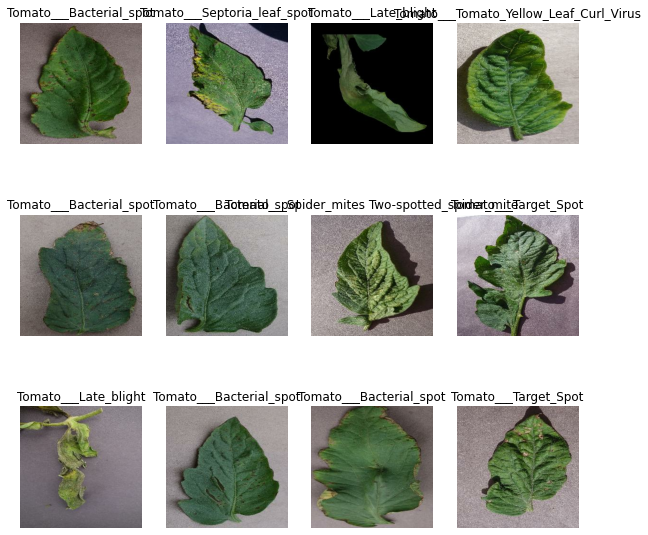

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.1,test_split=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split *ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg,
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
    
])
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (32, 32768)               0         
_________________________________________________________________
dense (Dense)                (32, 64)                  2097216   
_________________________________________________________________
dense_1 (Dense)              (32, 10)                  650       
Total params: 22,122,250
Trainable params: 2,097,866
Non-trainable params: 20,024,384
__________________________________

In [18]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
357/357 [==============================] - 46s 104ms/step - loss: 1.4571 - accuracy: 0.5029 - val_loss: 1.0915 - val_accuracy: 0.6214
Epoch 2/100
357/357 [==============================] - 30s 85ms/step - loss: 1.0106 - accuracy: 0.6424 - val_loss: 0.9755 - val_accuracy: 0.6655
Epoch 3/100
357/357 [==============================] - 30s 85ms/step - loss: 0.8747 - accuracy: 0.6813 - val_loss: 0.8399 - val_accuracy: 0.7173
Epoch 4/100
357/357 [==============================] - 31s 85ms/step - loss: 0.8059 - accuracy: 0.7123 - val_loss: 0.9035 - val_accuracy: 0.6882
Epoch 5/100
357/357 [==============================] - 31s 86ms/step - loss: 0.7518 - accuracy: 0.7296 - val_loss: 0.8770 - val_accuracy: 0.6839
Epoch 6/100
357/357 [==============================] - 30s 85ms/step - loss: 0.7205 - accuracy: 0.7389 - val_loss: 0.7018 - val_accuracy: 0.7536
Epoch 7/100
357/357 [==============================] - 31s 86ms/step - loss: 0.6769 - accuracy: 0.7590 - val_loss: 0.6637 - val_a

In [20]:
scores = model.evaluate(test_ds)

46/46 [==============================] - 9s 74ms/step - loss: 0.5897 - accuracy: 0.8186 0s - loss: 0.5811 - accuracy: 0.


In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 357}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
history.history['accuracy']

[0.5029326677322388,
 0.6423881649971008,
 0.6813446283340454,
 0.7123347520828247,
 0.7295806407928467,
 0.7388601899147034,
 0.758994996547699,
 0.7650354504585266,
 0.7749277949333191,
 0.7887595295906067,
 0.7928740382194519,
 0.7959380149841309,
 0.7912982702255249,
 0.8037292957305908,
 0.8079313635826111,
 0.819749653339386,
 0.8107327222824097,
 0.8196620941162109,
 0.8208876848220825,
 0.8267530202865601,
 0.830780029296875,
 0.8287665247917175,
 0.8376083374023438,
 0.8364703059196472,
 0.8361201286315918,
 0.841810405254364,
 0.8348945379257202,
 0.8351571559906006,
 0.8394467234611511,
 0.8469753861427307,
 0.8413726687431335,
 0.8446992635726929,
 0.8439989686012268,
 0.8475881814956665,
 0.8520528674125671,
 0.85441654920578,
 0.8503895401954651,
 0.8524030447006226,
 0.8564299941062927,
 0.8498643040657043,
 0.8578307032585144,
 0.8584434986114502,
 0.8616825938224792,
 0.8594940304756165,
 0.8636960387229919,
 0.8627330660820007,
 0.8634334206581116,
 0.8605445027351379

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

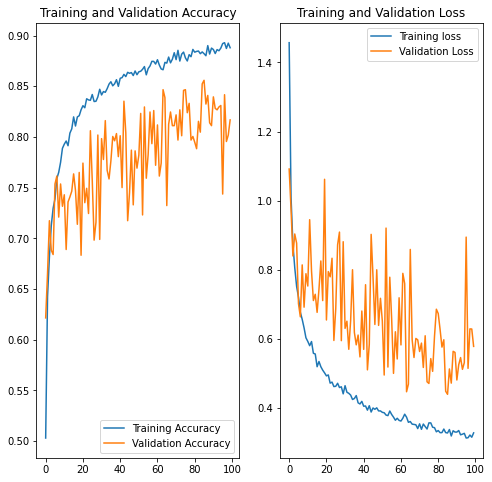

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label= 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first_image to predict
actual label: Tomato___Late_blight
tf.Tensor(2, shape=(), dtype=int32)
predicted label: Tomato___Late_blight


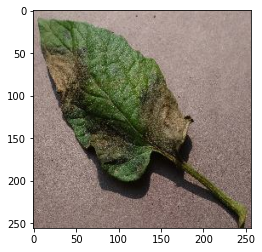

In [27]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first_image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    print(labels_batch[0])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

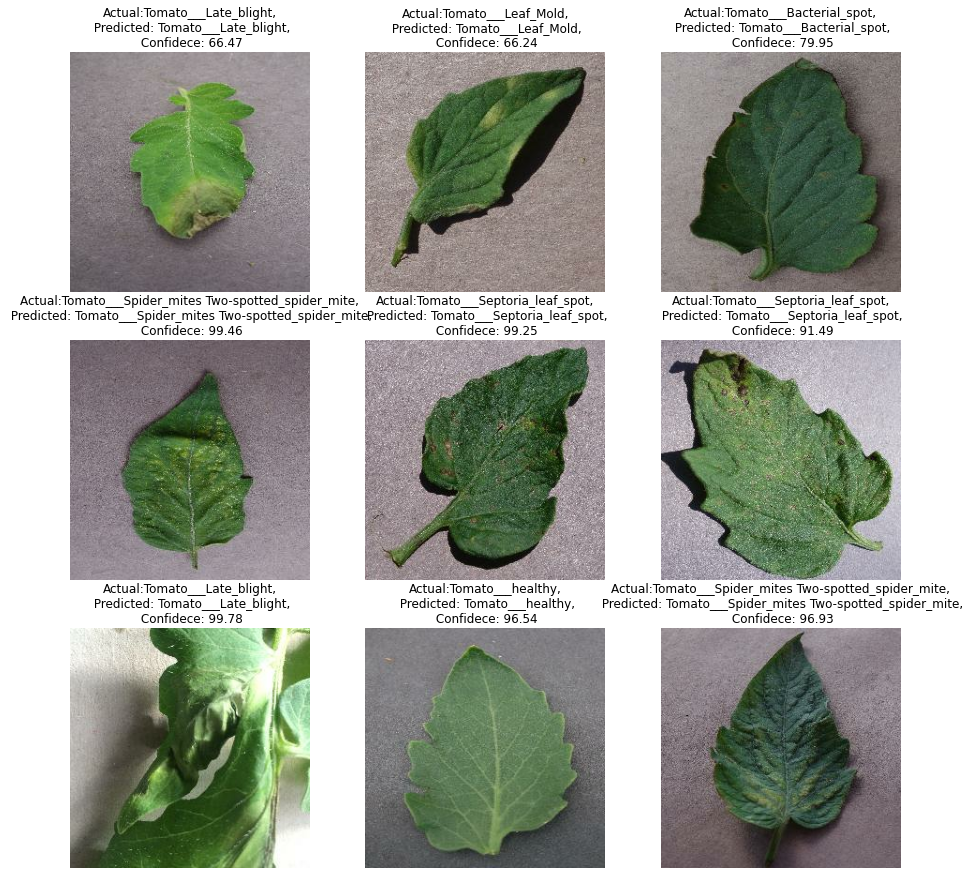

In [29]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidece: {confidence}")
        
        plt.axis("off")

In [38]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('Models/vgg_1900.h5')

In [31]:
#model = models.load_model('Models/vgg_1900.h5')

In [32]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [33]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools
cm=confusion_matrix(predicted_labels, correct_labels)
cm

array([[226,   7,  11,   0,   9,   0,   0,   5,   0,   0],
       [  0,  35,   1,   0,   0,   0,   0,   2,   0,   0],
       [  0,  22, 164,   9,   1,   0,   0,   0,   0,   0],
       [  0,   0,   2,  62,   0,   0,   0,   0,   0,   0],
       [  3,   8,   2,   5, 151,   0,   0,   0,   1,   0],
       [  2,   9,   5,  11,   0, 151,  16,  12,   3,   0],
       [  5,  16,   6,   2,  12,   4, 107,   0,   0,   0],
       [  2,   2,   0,   4,   0,   0,   0, 130,   0,   0],
       [  0,   0,   0,   3,   1,   0,   0,   0,  27,   0],
       [  0,   1,   2,   5,   6,  14,  35,   0,   1, 152]], dtype=int64)

In [34]:
target_names = []
for key in dataset.class_names:
    target_names.append(key)

In [35]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


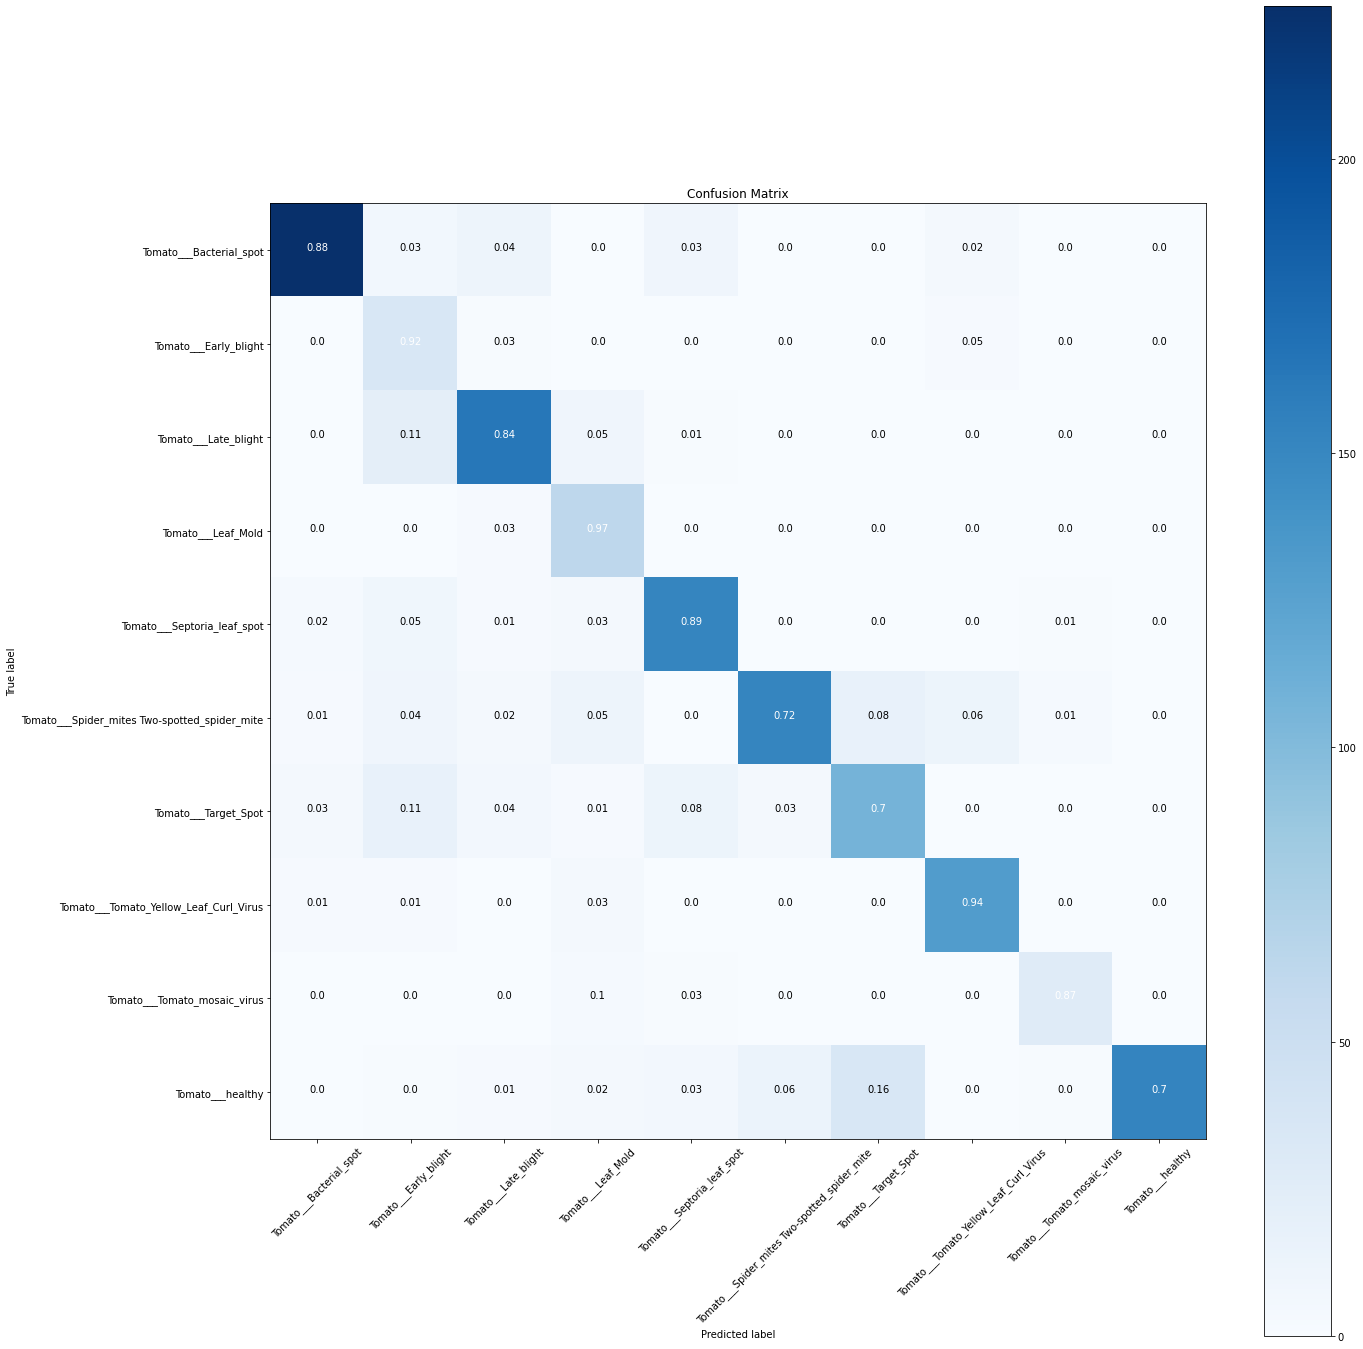

In [36]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
 

In [37]:
print('Classification Report')
print(classification_report(correct_labels,predicted_labels,target_names=target_names))

Classification Report
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.88      0.95      0.91       238
                        Tomato___Early_blight       0.92      0.35      0.51       100
                         Tomato___Late_blight       0.84      0.85      0.84       193
                           Tomato___Leaf_Mold       0.97      0.61      0.75       101
                  Tomato___Septoria_leaf_spot       0.89      0.84      0.86       180
Tomato___Spider_mites Two-spotted_spider_mite       0.72      0.89      0.80       169
                         Tomato___Target_Spot       0.70      0.68      0.69       158
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.94      0.87      0.91       149
                 Tomato___Tomato_mosaic_virus       0.87      0.84      0.86        32
                             Tomato___healthy       0.70      1.00      0.83       152

                   